In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LeakyReLU,Dropout, MaxPooling1D, MaxPool1D, Flatten, Dense 
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

from hyperas.distributions import choice, uniform

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("/home/hasan/Data Set/heart beat classification/archive(2)/mitbih_train.csv", header=None)
test = pd.read_csv("/home/hasan/Data Set/heart beat classification/archive(2)/mitbih_test.csv", header=None)

normal = pd.read_csv("/home/hasan/Data Set/heart beat classification/archive(2)/ptbdb_normal.csv", header=None)
abnormal = pd.read_csv("/home/hasan/Data Set/heart beat classification/archive(2)/ptbdb_abnormal.csv", header=None)


In [3]:
# Shape of every dataset
print(train.shape, test.shape, normal.shape, abnormal.shape)

(87554, 188) (21892, 188) (4046, 188) (10506, 188)


In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# From float to int of label column 
train[187] = train[187].astype(int)
test[187] = test[187].astype(int)
normal[187] = normal[187].astype(int)
abnormal[187] = abnormal[187].astype(int)


In [6]:
# counting the class label 
train_label_count = train[187].value_counts()
test_label_count = test[187].value_counts()
normal_label_count = normal[187].value_counts()
abnormal_label_count = abnormal[187].value_counts()

In [7]:
# counting every class of train dataset 
train_label_count

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

<AxesSubplot:>

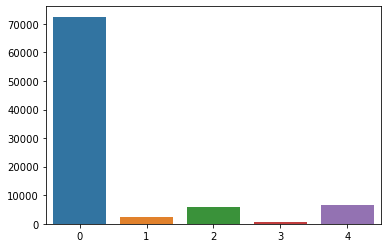

In [8]:
sns.barplot(x = train_label_count.index, y=train_label_count.values)

It is clear that the train-dataset is totally unlevel 

<AxesSubplot:>

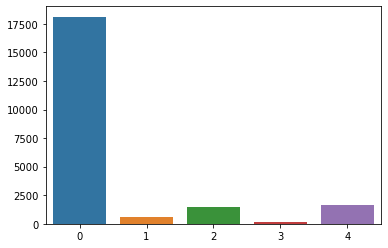

In [9]:
sns.barplot(x = test_label_count.index, y=test_label_count.values)

<AxesSubplot:>

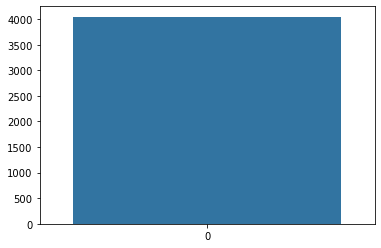

In [10]:
sns.barplot(x = normal_label_count.index, y=normal_label_count.values)

<AxesSubplot:>

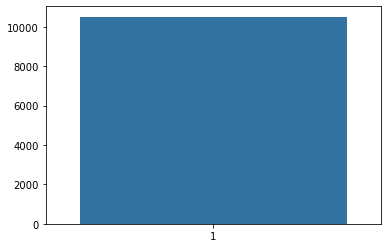

In [11]:
sns.barplot(x = abnormal_label_count.index, y=abnormal_label_count.values)

# Fixing unlabel problem of train

### Technique 1

In [12]:
df1 = train[train[187]==1]
df2 = train[train[187]==2]
df3 = train[train[187]==3]
df4 = train[train[187]==4]

In [13]:
df0 = train[train[187]==0].sample(n=30000, random_state=42)
df1 = resample(df1, replace=True, n_samples=30000, random_state=123)
df2 = resample(df2, replace=True, n_samples=30000, random_state=123)
df3 = resample(df3, replace=True, n_samples=30000, random_state=123)
df4 = resample(df4, replace=True, n_samples=30000, random_state=123)

In [14]:
train_df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)

I am not going to use this technique because there are lots of duplicated data. Those duplicated data will created bad decision during testing

In [15]:
train_df.shape

(150000, 188)

In [16]:
# Checking duplicate data
train_df.duplicated().sum()

104997

### Technique 2

In [17]:
df0 = train[train[187]==0].sample(n=800, random_state=42)
df1 = train[train[187]==1].sample(n=800, random_state=42)
df2 = train[train[187]==2].sample(n=800, random_state=42)
df3 = train[train[187]==3].sample(n=641, random_state=42)
df4 = train[train[187]==4].sample(n=800, random_state=42)

In [18]:
train_new = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)

In [19]:
# Shape of the dataset 
train_new.shape

(3841, 188)

In [20]:
# Checking duplicated
train_new.duplicated().sum()

0

In [21]:
train_new.iloc[:, -1].value_counts()

1    800
4    800
2    800
0    800
3    641
Name: 187, dtype: int64

# Some Visualization

In [22]:
train_new.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.162791,0.540698,0.755814,0.186047,0.168605,0.546512,0.616279,0.697674,0.651163,0.703488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.990066,0.938742,0.344371,0.034768,0.273179,0.331126,0.326159,0.341060,0.347682,0.347682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.974239,0.932084,0.590164,0.131148,0.014052,0.168618,0.238876,0.210773,0.196721,0.208431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Text(0.5, 1.0, 'ECG Normal')

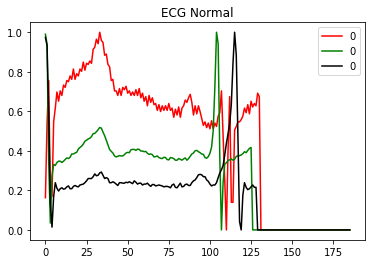

In [23]:
# Some data visualization where label=0
df0 = train_new[train_new[187]==0].head(3)
plt.plot(df0.iloc[0, :186], label='0', color='red')
plt.plot(df0.iloc[1, :186], label='0', color='green')
plt.plot(df0.iloc[2, :186], label='0', color='black')
plt.legend()
plt.title("ECG Normal")

Text(0.5, 1.0, 'ECG Artial Premature')

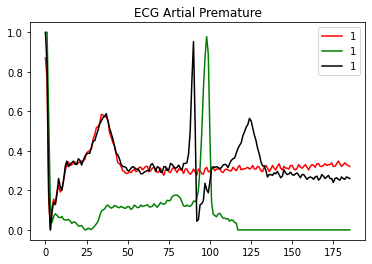

In [24]:
# Some data visualization where label=1
df1 = train_new[train_new[187]==1].head(3)
plt.plot(df1.iloc[0, :186], label='1', color='red')
plt.plot(df1.iloc[1, :186], label='1', color='green')
plt.plot(df1.iloc[2, :186], label='1', color='black')
plt.legend()
plt.title("ECG Artial Premature")

Text(0.5, 1.0, 'ECG Premature ventricular contraction')

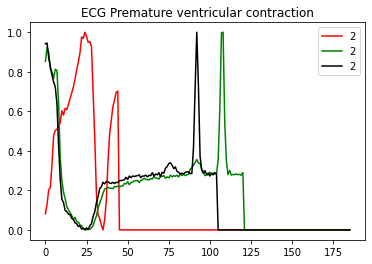

In [25]:
# Some data visualization where label=2
df2 = train_new[train_new[187]==2].head(3)
plt.plot(df2.iloc[0, :186], label='2', color='red')
plt.plot(df2.iloc[1, :186], label='2', color='green')
plt.plot(df2.iloc[2, :186], label='2', color='black')
plt.legend()
plt.title("ECG Premature ventricular contraction")

Text(0.5, 1.0, 'ECG Fusion of ventricular and normal')

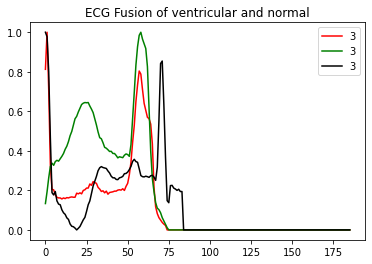

In [26]:
# Some data visualization where label=3
df3 = train_new[train_new[187]==3].head(3)
plt.plot(df3.iloc[0, :186], label='3', color='red')
plt.plot(df3.iloc[1, :186], label='3', color='green')
plt.plot(df3.iloc[2, :186], label='3', color='black')
plt.legend()
plt.title("ECG Fusion of ventricular and normal")

Text(0.5, 1.0, 'ECG Fusion of paced and normal')

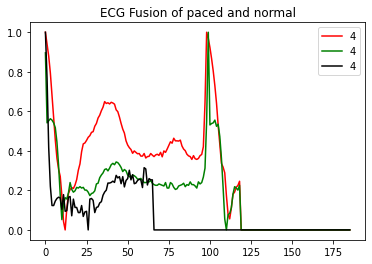

In [27]:
# Some data visualization where label=4
df4 = train_new[train_new[187]==4].head(3)
plt.plot(df4.iloc[0, :186], label='4', color='red')
plt.plot(df4.iloc[1, :186], label='4', color='green')
plt.plot(df4.iloc[2, :186], label='4', color='black')
plt.legend()
plt.title("ECG Fusion of paced and normal")

In [28]:
# One row from every class 
uni_cls = train_new.groupby(187, group_keys=False).apply(lambda train_new: train_new.sample(1))
uni_cls

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
388,1.000000,0.839590,0.261092,0.010239,0.155290,0.230375,0.247440,0.271331,0.284983,0.273038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
898,0.816547,0.381295,0.089928,0.212230,0.219424,0.219424,0.208633,0.212230,0.205036,0.223022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2229,0.000000,0.005398,0.175439,0.425101,0.565452,0.542510,0.550607,0.631579,0.663968,0.647773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2543,1.000000,0.782934,0.532934,0.264970,0.094311,0.109281,0.104790,0.076347,0.064371,0.052395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3168,1.000000,0.813953,0.465116,0.182724,0.056478,0.073090,0.073090,0.076412,0.076412,0.076412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Text(0.5, 1.0, 'ECG of Unique Five Classes')

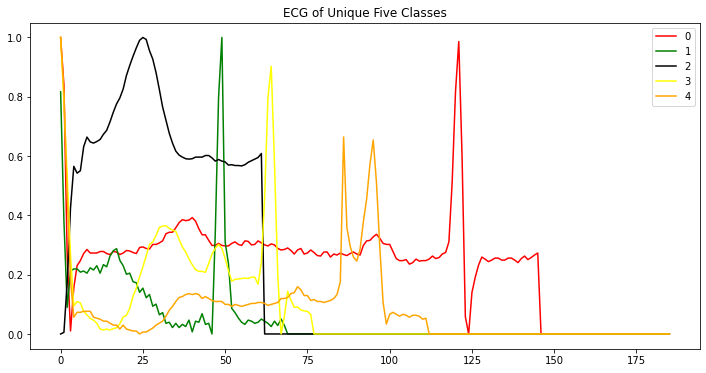

In [29]:
plt.figure(figsize=(12,6))
plt.plot(uni_cls.iloc[0, :186], label='0', color='red')
plt.plot(uni_cls.iloc[1, :186], label='1', color='green')
plt.plot(uni_cls.iloc[2, :186], label='2', color='black')
plt.plot(uni_cls.iloc[3, :186], label='3', color='yellow')
plt.plot(uni_cls.iloc[4, :186], label='4', color='orange')
plt.legend()
plt.title("ECG of Unique Five Classes")

# Shuffle Dataset

In [30]:
train_new = train_new.sample(frac=1).reset_index(drop=True)
test_new = test.sample(frac=1).reset_index(drop=True) 

In [31]:
print("Train data shape : {} Test data shape : {}".format(train_new.shape, test_new.shape))

Train data shape : (3841, 188) Test data shape : (21892, 188)


# Features and Label

In [32]:
# For training and validation
X = train_new.drop(187, axis=1)
y = train_new[187] 

# For Testing
x_test = test_new.drop(187, axis=1)
y_test = test_new[187] 

In [33]:
print(X.shape, y.shape, x_test.shape, y_test.shape)

(3841, 187) (3841,) (21892, 187) (21892,)


# Train, Valid dataset

In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=.1, random_state=42, stratify=y)

In [35]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(3456, 187) (385, 187) (3456,) (385,)


# Normalize and Standardize

In [36]:
# Data Normalize
scaler = MinMaxScaler()
normalized_xtrain = scaler.fit_transform(x_train)
#normalized_xtest = scaler.fit_transform(x_valid)


# Data Standardize
std = StandardScaler()
standardized_xtrain = scaler.fit_transform(normalized_xtrain)
#standardized_xtest = scaler.fit_transform(normalized_xtest)

# Reshaping dataset for Convolutional Layer

In [58]:
X_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
X_valid = np.array(x_valid).reshape(x_valid.shape[0], x_valid.shape[1], 1)
X_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
#y_train_ohe = to_categorical(y_train, num_classes=5)
#y_valid_ohe = to_categorical(y_valid, num_classes=5)
#y_test_ohe = to_categorical(y_test, num_classes=5)

In [56]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


(3456, 187, 1) (385, 187, 1) (3456,) (385,)


# Model

In [39]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=(5,), padding='same', activation=LeakyReLU(alpha=0.001), input_shape=(X_train.shape[1], 1) ))
model.add(Conv1D(filters=64, kernel_size=(5,), padding='same', activation=LeakyReLU(alpha=0.001) ))
model.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation=LeakyReLU(alpha=0.001) ))
model.add(MaxPool1D(pool_size=(5,), strides=2, padding='same' ))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=512, activation=LeakyReLU(alpha=0.001) ))
model.add(Dense(units=1024, activation=LeakyReLU(alpha=0.001) ))
model.add(Dense(5, activation='softmax'))


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 187, 32)           192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 187, 64)           10304     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 187, 128)          41088     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 94, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 94, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12032)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               6

In [41]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [42]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tensorflow.math.exp(-.1) 


callback = [ 
            EarlyStopping(monitor='val_loss',
                          patience=3,
                          mode='auto'
                         ),
            ModelCheckpoint(filepath='best_model.h5', 
                            monitor='val_loss', 
                            save_best_only=True
                           ),
            LearningRateScheduler(scheduler
                                  )
            ]


In [43]:
history = model.fit(X_train, y_train, 
                    batch_size=32,
                    steps_per_epoch=len(X_train) // 128,
                    epochs=30,
                    callbacks=callback,
                    validation_data=(X_valid, y_valid),
                    validation_steps=len(X_valid) // 64,
                    )

Epoch 1/30
27/27 [==============================] - 3s 124ms/step - loss: 1.1219 - accuracy: 0.5417 - val_loss: 0.8804 - val_accuracy: 0.6302
Epoch 2/30
27/27 [==============================] - 3s 109ms/step - loss: 0.7376 - accuracy: 0.7153 - val_loss: 0.6417 - val_accuracy: 0.7448
Epoch 3/30
27/27 [==============================] - 3s 111ms/step - loss: 0.5667 - accuracy: 0.7824 - val_loss: 0.6047 - val_accuracy: 0.7760
Epoch 4/30
27/27 [==============================] - 3s 108ms/step - loss: 0.5518 - accuracy: 0.7951 - val_loss: 0.5063 - val_accuracy: 0.7917
Epoch 5/30
27/27 [==============================] - 3s 106ms/step - loss: 0.4632 - accuracy: 0.8310 - val_loss: 0.4914 - val_accuracy: 0.8021
Epoch 6/30
27/27 [==============================] - 3s 111ms/step - loss: 0.4447 - accuracy: 0.8333 - val_loss: 0.4635 - val_accuracy: 0.8438
Epoch 7/30
27/27 [==============================] - 2s 81ms/step - loss: 0.4651 - accuracy: 0.8333 - val_loss: 0.4885 - val_accuracy: 0.8073
Epoch 8

# Accuracy and Loss Graph

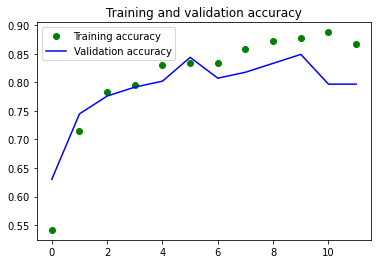

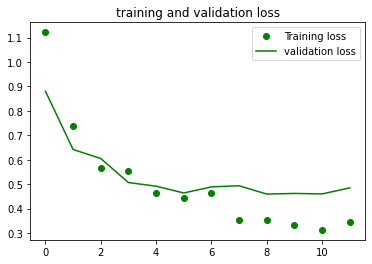

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# Model Evaluate

In [45]:
model.evaluate(X_test, y_test.values, verbose=2)

685/685 - 10s - loss: 0.5108 - accuracy: 0.8187


[0.5108053684234619, 0.818700909614563]

# Predict with test dataset

In [46]:
y_predicted = model.predict(X_test)

# Classification Report

In [47]:
y_test_ohe = to_categorical(y_test)
#y_test_ohe

In [48]:
# Classification Report
print(classification_report(y_test_ohe, y_predicted.round())) 

              precision    recall  f1-score   support

           0       0.99      0.77      0.86     18118
           1       0.15      0.82      0.26       556
           2       0.90      0.73      0.81      1448
           3       0.44      0.72      0.55       162
           4       0.82      0.96      0.89      1608

   micro avg       0.84      0.78      0.81     21892
   macro avg       0.66      0.80      0.67     21892
weighted avg       0.94      0.78      0.84     21892
 samples avg       0.78      0.78      0.78     21892



# Confusion Matrix

In [56]:
pred = y_predicted.round()
pred

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [57]:
p = []
for i in range(len(pred)):
    p.append(np.argmax(pred[i]))

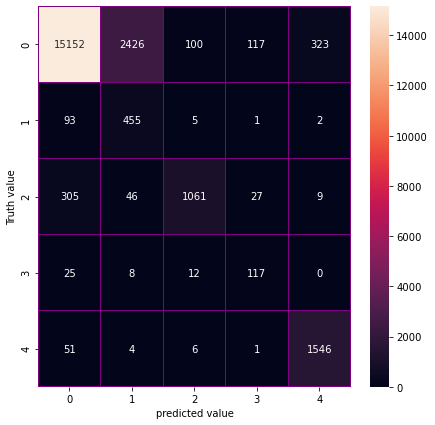

In [58]:
cm = confusion_matrix(y_test, p)
plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()

# Roc Auc Score

In [59]:
y_test_arr = y_test.values
y_test_arr

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
# predict probabilities
lr_probs = model.predict(X_test)

# calculate scores
lr_auc = roc_auc_score(y_test_arr, lr_probs, multi_class='ovr')

# summarize scores
print('Deep Learning: ROC AUC=%.3f' % (lr_auc))

Deep Learning: ROC AUC=0.966


In [61]:
fpr = {}
tpr = {}
thresh = {}
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_arr, lr_probs[:,i], pos_label=i)


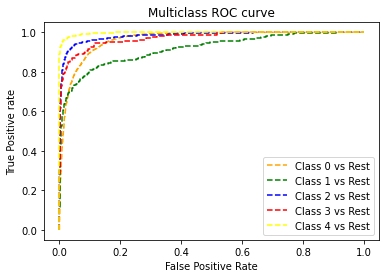

In [62]:
plt.plot(fpr[0], tpr[0], linestyle='--', color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--', color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--', color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--', color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--', color='yellow', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC', dpi=300)



# Working with Normal and Abnormal

In [63]:
df = pd.concat([normal, abnormal], ignore_index=True)
print(df.shape)

(14552, 188)


In [64]:
df[187].value_counts()

1    10506
0     4046
Name: 187, dtype: int64

In [65]:
X = df.drop(187, axis=1)
y = df[187]


In [66]:
x_train, X_test, y_train, Y_test = train_test_split(X,y, test_size=.1, random_state=42, stratify=y)


In [67]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=.1, random_state=42, stratify=y_train) 

In [68]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = np.array(X_valid).reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

#y_train_ohe = to_categorical(Y_train, num_classes=2)
#y_valid_ohe = to_categorical(Y_valid, num_classes=2)
#y_test_ohe = to_categorical(Y_test, num_classes=2)


In [69]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

(11786, 187, 1) (1310, 187, 1) (1456, 187, 1)
(11786,) (1310,) (1456,)


In [70]:
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=(5,), padding='same', activation=LeakyReLU(alpha=0.001), input_shape=(X_train.shape[1], 1) ))
model2.add(Conv1D(filters=64, kernel_size=(5,), padding='same', activation=LeakyReLU(alpha=0.001) ))
model2.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation=LeakyReLU(alpha=0.001) ))
model2.add(MaxPool1D(pool_size=(5,), strides=2, padding='same' ))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(units=512, activation=LeakyReLU(alpha=0.001) ))
model2.add(Dense(units=1024, activation=LeakyReLU(alpha=0.001) ))
model2.add(Dense(2, activation='softmax'))


In [71]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 187, 32)           192       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 187, 64)           10304     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 187, 128)          41088     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 94, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 94, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12032)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [72]:
model2.compile(optimizer='adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [73]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tensorflow.math.exp(-.1) 


callback = [ 
            EarlyStopping(monitor='val_loss',
                          patience=3,
                          mode='auto'
                         ),
            ModelCheckpoint(filepath='best_model.h5', 
                            monitor='val_loss', 
                            save_best_only=True
                           ),
            LearningRateScheduler(scheduler
                                  )
            ]

In [74]:
history = model2.fit(X_train, Y_train, 
                    batch_size=32,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=30,
                    callbacks=callback,
                    validation_data=(X_valid, Y_valid),
                    validation_steps=len(X_valid) // 32,
                    )

Epoch 1/30
368/368 [==============================] - 30s 81ms/step - loss: 0.2848 - accuracy: 0.8740 - val_loss: 0.1265 - val_accuracy: 0.9539
Epoch 2/30
368/368 [==============================] - 30s 83ms/step - loss: 0.1313 - accuracy: 0.9513 - val_loss: 0.0573 - val_accuracy: 0.9758
Epoch 3/30
368/368 [==============================] - 30s 83ms/step - loss: 0.0704 - accuracy: 0.9740 - val_loss: 0.0550 - val_accuracy: 0.9805
Epoch 4/30
368/368 [==============================] - 32s 88ms/step - loss: 0.0450 - accuracy: 0.9835 - val_loss: 0.0228 - val_accuracy: 0.9914
Epoch 5/30
368/368 [==============================] - 32s 87ms/step - loss: 0.0371 - accuracy: 0.9869 - val_loss: 0.0322 - val_accuracy: 0.9891
Epoch 6/30
368/368 [==============================] - 29s 78ms/step - loss: 0.0340 - accuracy: 0.9879 - val_loss: 0.0175 - val_accuracy: 0.9953
Epoch 7/30
368/368 [==============================] - 28s 77ms/step - loss: 0.0219 - accuracy: 0.9914 - val_loss: 0.0300 - val_accuracy:

# Accuracy and Loss Graph

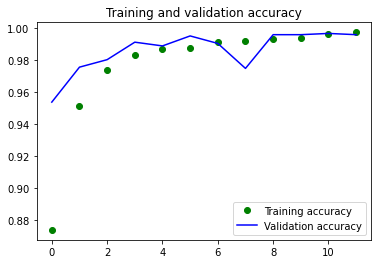

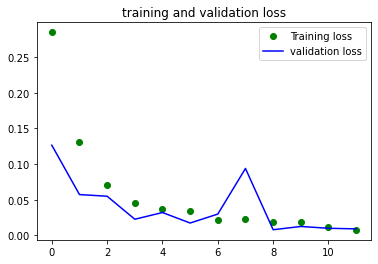

In [75]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# Model Evaluation

In [76]:
model2.evaluate(X_test, Y_test.values, verbose=2)

46/46 - 1s - loss: 0.0300 - accuracy: 0.9931


[0.030004139989614487, 0.9931318759918213]

# Prediction with test data

In [77]:
predicted = model2.predict(X_test) 

# Classification Report

In [78]:
Y_test_ohe = to_categorical(Y_test)
Y_test_ohe

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [79]:
print(classification_report(Y_test_ohe, predicted.round() )) 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       405
           1       1.00      1.00      1.00      1051

   micro avg       0.99      0.99      0.99      1456
   macro avg       0.99      0.99      0.99      1456
weighted avg       0.99      0.99      0.99      1456
 samples avg       0.99      0.99      0.99      1456



# Confusion Matrix

In [82]:
p2 = []
for i in range(len(Y_test)):
    p2.append(np.argmax(predicted[i]))
    

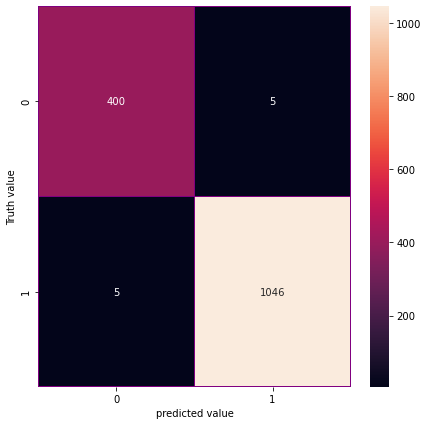

In [83]:
cm = confusion_matrix(Y_test, p2)
plt.figure(figsize=(7,7))
sns.heatmap(cm, fmt='.0f', annot=True, linewidths=0.2, linecolor='purple')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()

# Roc Auc Score and Graph

In [84]:
ns_probs = [0 for _ in range(len(Y_test))]
# predict probabilities
#lr_probs = model2.predict(X_test)

# keep probabilities for the positive outcome only
lr_probs = p2 #lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Deep Learning: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Deep Learning: ROC AUC=0.991


In [85]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

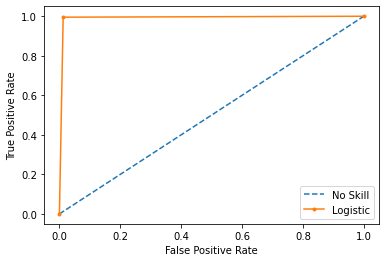

In [86]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()